In [ ]:
!pip install numpy opencv-python scikit-image svgwrite ipywidgets
!jupyter nbextension enable --py widgetsnbextension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 654.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
import numpy as np
import cv2
from skimage.morphology import thin
import svgwrite
from scipy.spatial.distance import euclidean
from IPython.display import SVG, display, clear_output
from google.colab import files
import math
import ipywidgets as widgets

In [ ]:
# 📤 Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]


Saving Colour_in_Salon_des_Cent_original.png to Colour_in_Salon_des_Cent_original.png


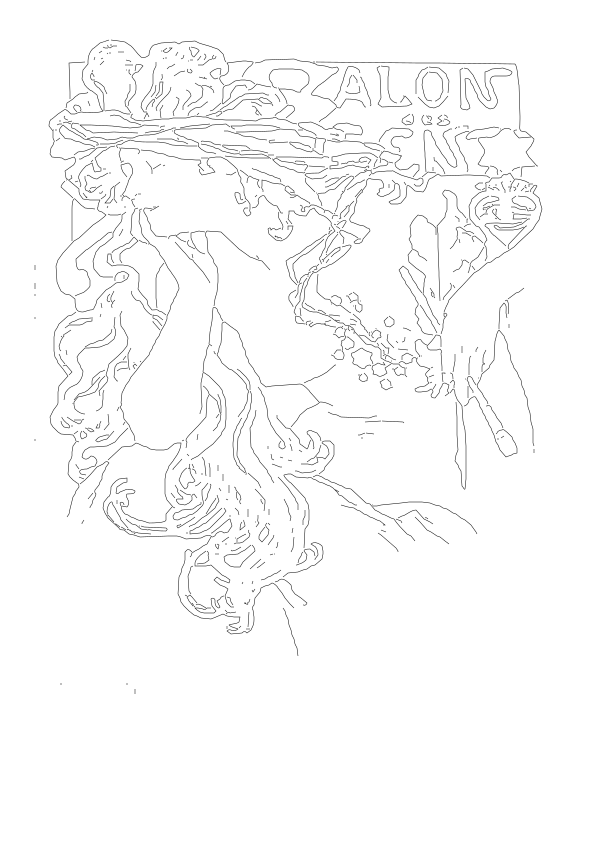

In [ ]:
# 📸 Load image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 🔳 Adaptive threshold
binary = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV, 15, 5)

# 🪶 Skeletonize
skeleton = thin(binary // 255).astype(np.uint8)

# 📡 Neighborhood offsets
neighbor_offsets = [(-1, -1), (-1, 0), (-1, 1),
                    (0, -1),          (0, 1),
                    (1, -1),  (1, 0),  (1, 1)]

def get_neighbors(y, x, skeleton, visited):
    neighbors = []
    h, w = skeleton.shape
    for dy, dx in neighbor_offsets:
        ny, nx = y + dy, x + dx
        if 0 <= ny < h and 0 <= nx < w:
            if skeleton[ny, nx] and not visited[ny, nx]:
                neighbors.append((ny, nx))
    return neighbors

# 🧵 Trace skeleton
def trace_paths(skeleton):
    visited = np.zeros_like(skeleton, dtype=bool)
    h, w = skeleton.shape
    paths = []
    for y in range(h):
        for x in range(w):
            if skeleton[y, x] and not visited[y, x]:
                path = []
                stack = [(y, x)]
                visited[y, x] = True
                while stack:
                    cy, cx = stack.pop()
                    path.append((cx, cy))
                    for ny, nx in get_neighbors(cy, cx, skeleton, visited):
                        visited[ny, nx] = True
                        stack.append((ny, nx))
                if len(path) > 2:
                    paths.append(path)
    return paths

paths = trace_paths(skeleton)

# ✂️ Split by gap
def split_path_by_gap(path, gap_threshold=2.0):
    if not path:
        return []
    subpaths = []
    current = [path[0]]
    for prev, curr in zip(path[:-1], path[1:]):
        dist = np.hypot(curr[0] - prev[0], curr[1] - prev[1])
        if dist > gap_threshold:
            if len(current) > 1:
                subpaths.append(current)
            current = [curr]
        else:
            current.append(curr)
    if len(current) > 1:
        subpaths.append(current)
    return subpaths

# 📐 Geometry helpers
def perpendicular_distance(point, start, end):
    if start == end:
        return euclidean(point, start)
    num = abs((end[0] - start[0]) * (start[1] - point[1]) -
              (start[0] - point[0]) * (end[1] - start[1]))
    denom = math.hypot(end[0] - start[0], end[1] - start[1])
    return num / denom

def angle_between(p1, p2, p3):
    a = np.array(p1)
    b = np.array(p2)
    c = np.array(p3)
    ab = a - b
    cb = c - b
    cosine_angle = np.dot(ab, cb) / (np.linalg.norm(ab) * np.linalg.norm(cb) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

# 🧠 Smart simplification with corner protection
def douglas_peucker_with_corners(points, epsilon, sharp_angle_deg=150):
    if len(points) < 3:
        return points

    start, end = points[0], points[-1]
    max_dist = 0
    index = 0

    for i in range(1, len(points) - 1):
        d = perpendicular_distance(points[i], start, end)
        if d > max_dist:
            max_dist = d
            index = i

    if max_dist > epsilon:
        left = douglas_peucker_with_corners(points[:index+1], epsilon, sharp_angle_deg)
        right = douglas_peucker_with_corners(points[index:], epsilon, sharp_angle_deg)
        return left[:-1] + right
    else:
        for i in range(1, len(points) - 1):
            angle = angle_between(points[i - 1], points[i], points[i + 1])
            if angle < sharp_angle_deg:
                left = douglas_peucker_with_corners(points[:i+1], epsilon, sharp_angle_deg)
                right = douglas_peucker_with_corners(points[i:], epsilon, sharp_angle_deg)
                return left[:-1] + right
        return [start, end]

def is_straight_line(points, tolerance=1.0):
    if len(points) <= 2:
        return True
    start = points[0]
    end = points[-1]
    for pt in points[1:-1]:
        if perpendicular_distance(pt, start, end) > tolerance:
            return False
    return True

# 🧩 Fit segments
def fit_segment_custom(segment, mode='auto', line_tolerance=1.0):
    if mode == 'line' or (mode == 'auto' and is_straight_line(segment, tolerance=line_tolerance)):
        return f"L {segment[-1][0]},{segment[-1][1]}"
    elif mode == 'quadratic' or (mode == 'auto' and len(segment) == 3):
        cx, cy = segment[1]
        x, y = segment[2]
        return f"Q {cx},{cy} {x},{y}"
    elif mode == 'cubic' or (mode == 'auto' and len(segment) >= 4):
        c1 = segment[1]
        c2 = segment[2]
        end = segment[3]
        return f"C {c1[0]},{c1[1]} {c2[0]},{c2[1]} {end[0]},{end[1]}"
    else:
        return ""

def segment_path(path, max_len=4):
    return [path[i:i+max_len] for i in range(0, len(path)-1, max_len-1)]

# 🎨 Generate SVG interactively
def generate_svg_interactive(epsilon=0.5, gap_threshold=2.0, line_tolerance=1.0,
                             sharp_angle_deg=150, fit_mode='auto'):
    h, w = skeleton.shape
    dwg = svgwrite.Drawing('interactive_output.svg', size=(w, h), profile='tiny')

    for path in paths:
        subpaths = split_path_by_gap(path, gap_threshold)
        for subpath in subpaths:
            simplified = douglas_peucker_with_corners(subpath, epsilon, sharp_angle_deg=sharp_angle_deg)
            if len(simplified) < 2:
                continue
            d = f"M {simplified[0][0]},{simplified[0][1]}"
            segments = segment_path(simplified, max_len=4)
            for seg in segments:
                d += " " + fit_segment_custom(seg, mode=fit_mode, line_tolerance=line_tolerance)
            dwg.add(dwg.path(d=d, stroke='black', fill='none', stroke_width=0.5))
    dwg.save()
    display(SVG('interactive_output.svg'))

# 🎛️ UI Controls
epsilon_slider = widgets.FloatSlider(value=0.5, min=0.1, max=3.0, step=0.1, description='Epsilon:')
gap_slider = widgets.FloatSlider(value=2.0, min=0.5, max=10.0, step=0.5, description='Gap:')
line_tol_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Line Tol:')
angle_slider = widgets.IntSlider(value=150, min=90, max=179, step=1, description='Corner:')
fit_mode_dropdown = widgets.Dropdown(
    options=['auto', 'line', 'quadratic', 'cubic'],
    value='auto',
    description='Fit Mode:'
)
update_button = widgets.Button(description="Generate SVG")

def on_update_clicked(b):
    clear_output(wait=True)
    display(ui)
    generate_svg_interactive(
        epsilon=epsilon_slider.value,
        gap_threshold=gap_slider.value,
        line_tolerance=line_tol_slider.value,
        sharp_angle_deg=angle_slider.value,
        fit_mode=fit_mode_dropdown.value
    )

update_button.on_click(on_update_clicked)

ui = widgets.VBox([
    epsilon_slider,
    gap_slider,
    line_tol_slider,
    angle_slider,
    fit_mode_dropdown,
    update_button
])

display(ui)
generate_svg_interactive()